# Assignment 1: French GDP, CPI, and intrest rates

First we import the relevant packages to read the data, and plot the graphs.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

We load the data from into a Pandas DataFrame object.

In [2]:
fr_fin_df = pd.read_csv("data.csv", index_col=0)
fr_fin_df = fr_fin_df.set_index("date", drop=True)
fr_fin_df.loc[:, "gdp-1"] = fr_fin_df["gdp"].shift(1)
fr_fin_df.loc[:, "gdp-2"] = fr_fin_df["gdp"].shift(2)
fr_fin_df.loc[:, "gdp-3"] = fr_fin_df["gdp"].shift(3)
fr_fin_df.loc[:, "ir-1"] = fr_fin_df["ir"].shift(1)
fr_fin_df.loc[:, "ir-2"] = fr_fin_df["ir"].shift(2)
fr_fin_df.loc[:, "ir-3"] = fr_fin_df["ir"].shift(3)
fr_fin_df.loc[:, "cpi-1"] = fr_fin_df["cpi"].shift(1)
fr_fin_df.loc[:, "cpi-2"] = fr_fin_df["cpi"].shift(2)
fr_fin_df.loc[:, "cpi-3"] = fr_fin_df["cpi"].shift(3)
fr_fin_df.index = pd.to_datetime(fr_fin_df.index)
fr_fin_df

,gdp,ir,cpi,gdp-1,gdp-2,gdp-3,ir-1,ir-2,ir-3,cpi-1,cpi-2,cpi-3
date,,,,,,,,,,,,
1970-01-01,1.911374,9.920000,5.526357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04-01,1.262038,9.186666,5.437259,1.911374,NaN,NaN,9.920000,NaN,NaN,5.526357,NaN,NaN
1970-07-01,1.377239,8.673333,5.275131,1.262038,1.911374,NaN,9.186666,9.920000,NaN,5.437259,5.526357,NaN
1970-10-01,1.570186,7.920000,4.971684,1.377239,1.262038,1.911374,8.673333,9.186666,9.920000,5.275131,5.437259,5.526357
1971-01-01,0.129083,6.376667,4.854039,1.570186,1.377239,1.262038,7.920000,8.673333,9.186666,4.971684,5.275131,5.437259
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01,0.583801,-0.315333,1.896263,0.383905,0.431768,0.081844,-0.319500,-0.325233,-0.328300,2.248264,1.895423,1.360432
2019-01-01,0.676134,-0.308533,1.221344,0.583801,0.383905,0.431768,-0.315333,-0.319500,-0.325233,1.896263,2.248264,1.895423
2019-04-01,0.687793,-0.317100,1.123850,0.676134,0.583801,0.383905,-0.308533,-0.315333,-0.319500,1.221344,1.896263,2.248264


## a. Exploratory look at the data
First we plot the data using the default plot data.

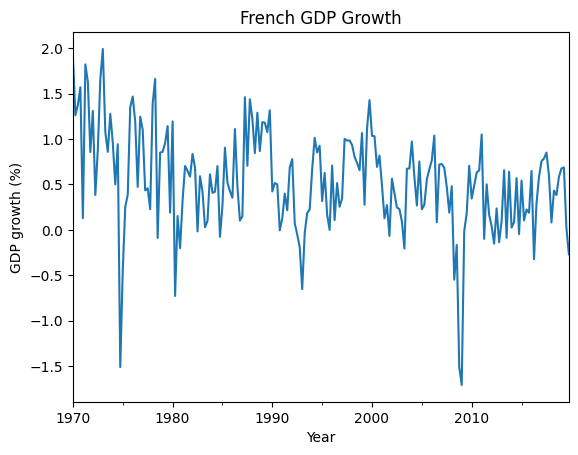

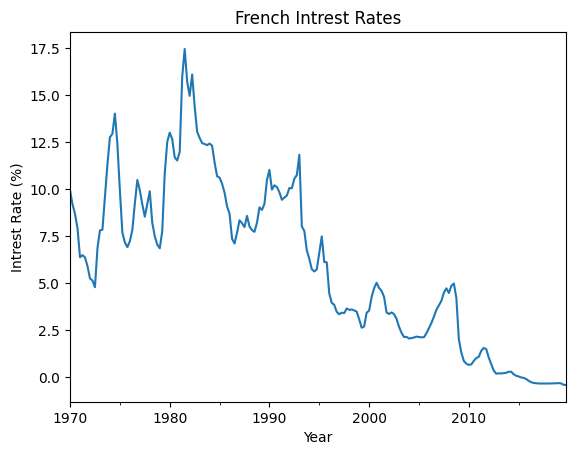

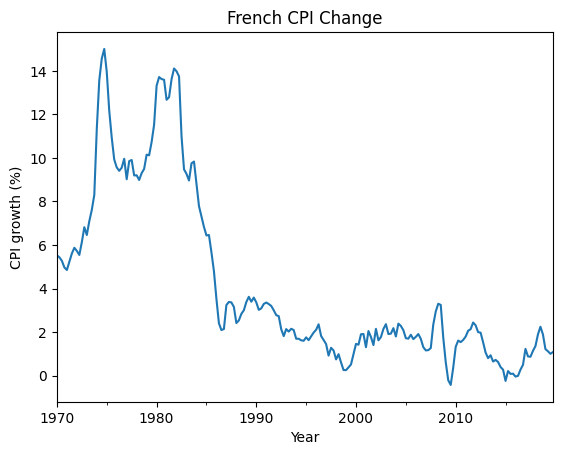

In [3]:
fr_fin_df["gdp"].plot.line(title="French GDP Growth", ylabel="GDP growth (%)", xlabel="Year")
plt.show()

fr_fin_df["ir"].plot.line(title="French Intrest Rates", ylabel="Intrest Rate (%)", xlabel="Year")
plt.show()

fr_fin_df["cpi"].plot.line(title="French CPI Change", ylabel="CPI growth (%)", xlabel="Year")
plt.show()

## b. Bivariate VAR(3) model: French GDP & Inflation Rate



In [4]:
# Note this code is needed just for assignment C, however this simplyfies the code a lot
def AIC(sigma_ML: pd.DataFrame, K: int, T: int, p: int) -> float:
    return np.log(np.linalg.det(sigma_ML)) + 2/T * (p * K**2 + K)

def HQ(sigma_ML: pd.DataFrame, K: int, T: int, p: int) -> float:
    return np.log(np.linalg.det(sigma_ML)) + ((2*np.log(np.log(T)))/T) * (p*K**2 + K)

def SC(sigma_ML: pd.DataFrame, K: int, T: int, p: int) -> float:
    return np.log(np.linalg.det(sigma_ML)) + (np.log(T)/T) * (p * K **2 + K)

In [5]:
def add_constant(data_df: pd.DataFrame):
    return pd.DataFrame(np.vstack([np.ones(len(data_df.columns)), data_df.values]), columns=data_df.columns, index=["const",]+list(data_df.index))

def VAR_estimation(p: int, Y_columns: set, data_df: pd.DataFrame):
    data_df = data_df.copy() # Ensure not changing the data
    Y: pd.DataFrame = data_df[list(Y_columns)].iloc[p:].T
    K = len(Y)
    p_len = p - 1
    Z: pd.DataFrame = add_constant(data_df[[f"{Y_column}-{i+1}" for i in range(p) for Y_column in Y_columns]].iloc[p:].T)
    B_hat: pd.DataFrame = Y @ Z.T @ np.linalg.inv(Z @ Z.T)
    B_hat.columns = Z.index
    T = len(Z.columns)

    A_hat = np.vstack((
        B_hat.iloc[:, 1:],
        np.hstack((np.eye(p_len*K), np.zeros((p_len * K,K)))) # Yes this code is stupid but it works
    ))

    eig_vals = np.linalg.eigvals(A_hat)
    if all(abs(eig_vals) < 1):
        print(f'The VAR({p}) model is stable.')
    else:
        print(f'The VAR({p}) model is unstable.')

    U_hat = Y - B_hat @ Z
    sigma_ML = 1/T * U_hat @ U_hat.T
    sigma_LS = 1/(T - K * p - 1) * U_hat @ U_hat.T

    _AIC = AIC(sigma_ML, K, T, p)
    _SC = SC(sigma_ML, K, T, p)
    _HQ = HQ(sigma_ML, K, T, p)

    criteria = pd.DataFrame([["AIC", "SC", "HQ"], [_AIC, _SC, _HQ]]).T.set_index(0)[1].rename_axis("Criteria").astype(float)

    return B_hat, criteria, Z, sigma_LS

B_hat, _, _, _ = VAR_estimation(3, {"gdp", "ir"}, fr_fin_df)
display(B_hat)

The VAR(3) model is stable.


,const,gdp-1,ir-1,gdp-2,ir-2,gdp-3,ir-3
gdp,0.185813,0.335254,0.033624,0.212869,-0.163911,0.087425,0.128776
ir,-0.138593,0.250578,1.279618,0.115121,-0.404075,0.082987,0.101202


## c. Model Selection
Choose between a VAR(1), VAR(2), or VAR(3) model, using a AIC, SC, or HQ.

In [6]:
B_hat_var1, criteria_var_1, _, _ = VAR_estimation(1, {"gdp", "ir"}, fr_fin_df.iloc[2:])
B_hat_var2, criteria_var_2, _, _ = VAR_estimation(2, {"gdp", "ir"}, fr_fin_df.iloc[1:])
B_hat_var3, criteria_var_3, _, _ = VAR_estimation(3, {"gdp", "ir"}, fr_fin_df)

print("VAR 1:")
display(B_hat_var1)
display(criteria_var_1)


print("VAR 2:")
display(B_hat_var2)
display(criteria_var_2)


print("VAR 3:")
display(B_hat_var3)
display(criteria_var_3)


The VAR(1) model is stable.
The VAR(2) model is stable.
The VAR(3) model is stable.
VAR 1:


,const,gdp-1,ir-1
gdp,0.283914,0.449154,-0.000176
ir,-0.175156,0.448387,0.981669


Criteria
AIC   -1.944026
SC    -1.844030
HQ    -1.903547
Name: 1, dtype: float64

VAR 2:


,const,gdp-1,ir-1,gdp-2,ir-2
gdp,0.239897,0.360284,-0.001479,0.199392,-0.001346
ir,-0.093849,0.273132,1.252559,0.109536,-0.276626


Criteria
AIC   -2.029909
SC    -1.863249
HQ    -1.962444
Name: 1, dtype: float64

VAR 3:


,const,gdp-1,ir-1,gdp-2,ir-2,gdp-3,ir-3
gdp,0.185813,0.335254,0.033624,0.212869,-0.163911,0.087425,0.128776
ir,-0.138593,0.250578,1.279618,0.115121,-0.404075,0.082987,0.101202


Criteria
AIC   -2.036876
SC    -1.803552
HQ    -1.942425
Name: 1, dtype: float64

The most conservative information criterion is the AIC, since for $T = 200$ has the lowest penalty for additional parameters, thus making it less conservative than the other two.

In [7]:
from statsmodels.tsa.vector_ar.api import VAR

t_var_1 = VAR(fr_fin_df[["gdp", "ir"]].iloc[2:]).fit(1)
t_var_2 = VAR(fr_fin_df[["gdp", "ir"]].iloc[1:]).fit(2)
t_var_3 = VAR(fr_fin_df[["gdp", "ir"]]).fit(3)

print(f"VAR(1) - AIC: {t_var_1.aic}, SC: {t_var_1.bic}, HQ: {t_var_1.hqic}")
print(f"VAR(2) - AIC: {t_var_2.aic}, SC: {t_var_2.bic}, HQ: {t_var_2.hqic}")
print(f"VAR(3) - AIC: {t_var_3.aic}, SC: {t_var_3.bic}, HQ: {t_var_3.hqic}")

VAR(1) - AIC: -1.94402582543126, SC: -1.8440297727793413, HQ: -1.9035466773795202
VAR(2) - AIC: -2.0299094862810785, SC: -1.863249398527881, HQ: -1.962444239528179
VAR(3) - AIC: -2.0368764523855236, SC: -1.8035523295310472, HQ: -1.9424251069314646


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


The statsmodels check confirms our result.

## d. Impulse Responses

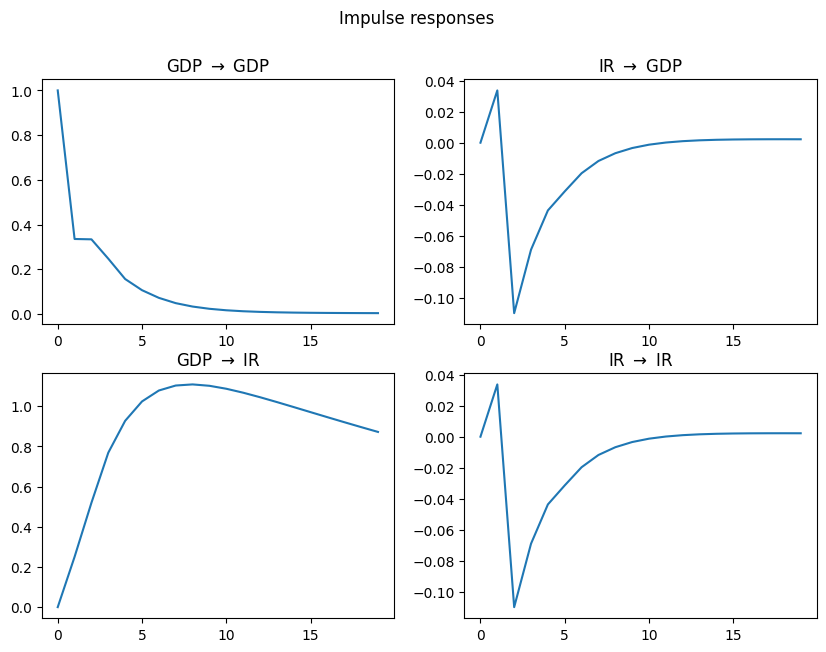

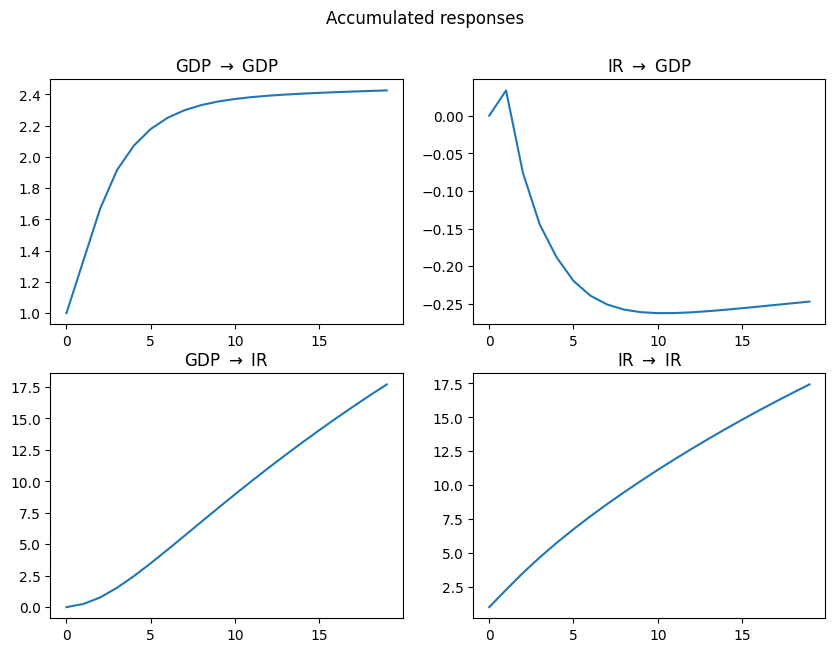

In [8]:
A_hat = B_hat.iloc[:, 1:] # Ignore the constant

def calculate_phi(A: pd.DataFrame, K: int, s: int, p: int):
    A: np.ndarray = A.values
    Phi = np.zeros((K, K*s))
    Phi[:K, :K] = np.identity(K)

    def _A(j: int):
        if j > p - 1:
            return np.zeros((K, K))
        
        return A[:, j*K:(j+1)*K]

    for i in range(s):
        for j in range(i):
            Phi[:, i*K:(i+1)*K] += Phi[:, (i-j - 1)*K:(i-j)*K] @ _A(j)
    
    return Phi

Phi_array = calculate_phi(A_hat, 2, 20, 3)
Psi_array = np.vstack([Phi_array[:, ::2].cumsum(axis=1), Phi_array[:, 1::2].cumsum(axis=1)])


fig, axs = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle("Impulse responses")

axs[0,0].set_title(r"GDP $\rightarrow$ GDP")
axs[0,0].plot(np.arange(20), Phi_array[0, ::2])
axs[0,1].set_title(r"IR $\rightarrow$ GDP")
axs[0,1].plot(np.arange(20), Phi_array[0, 1::2])
axs[1,0].set_title(r"GDP $\rightarrow$ IR")
axs[1,0].plot(np.arange(20), Phi_array[1, ::2])
axs[1,1].set_title(r"IR $\rightarrow$ IR")
axs[1,1].plot(np.arange(20), Phi_array[0, 1::2])
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle("Accumulated responses")

axs[0,0].set_title(r"GDP $\rightarrow$ GDP")
axs[0,0].plot(np.arange(20), Psi_array[0])
axs[0,1].set_title(r"IR $\rightarrow$ GDP")
axs[0,1].plot(np.arange(20), Psi_array[2])
axs[1,0].set_title(r"GDP $\rightarrow$ IR")
axs[1,0].plot(np.arange(20), Psi_array[1])
axs[1,1].set_title(r"IR $\rightarrow$ IR")
axs[1,1].plot(np.arange(20), Psi_array[3])
plt.show()

Below we double check our results with the statsmodels implementation.

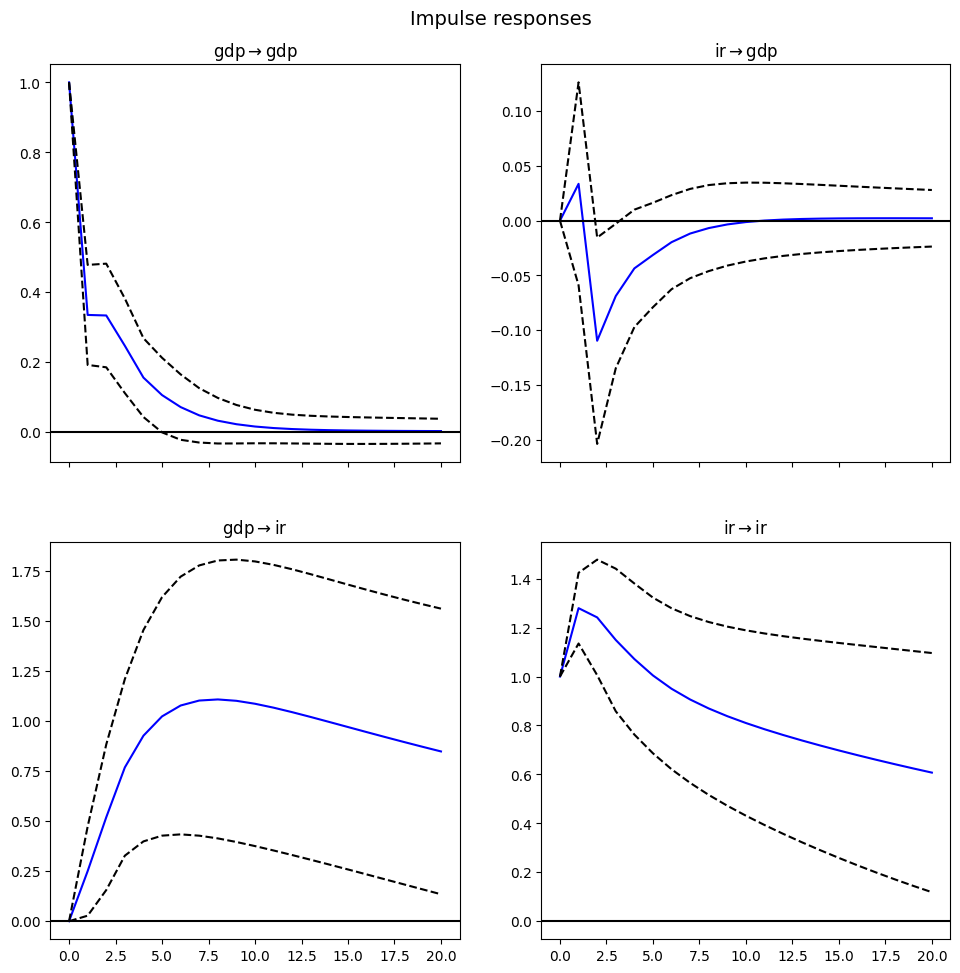

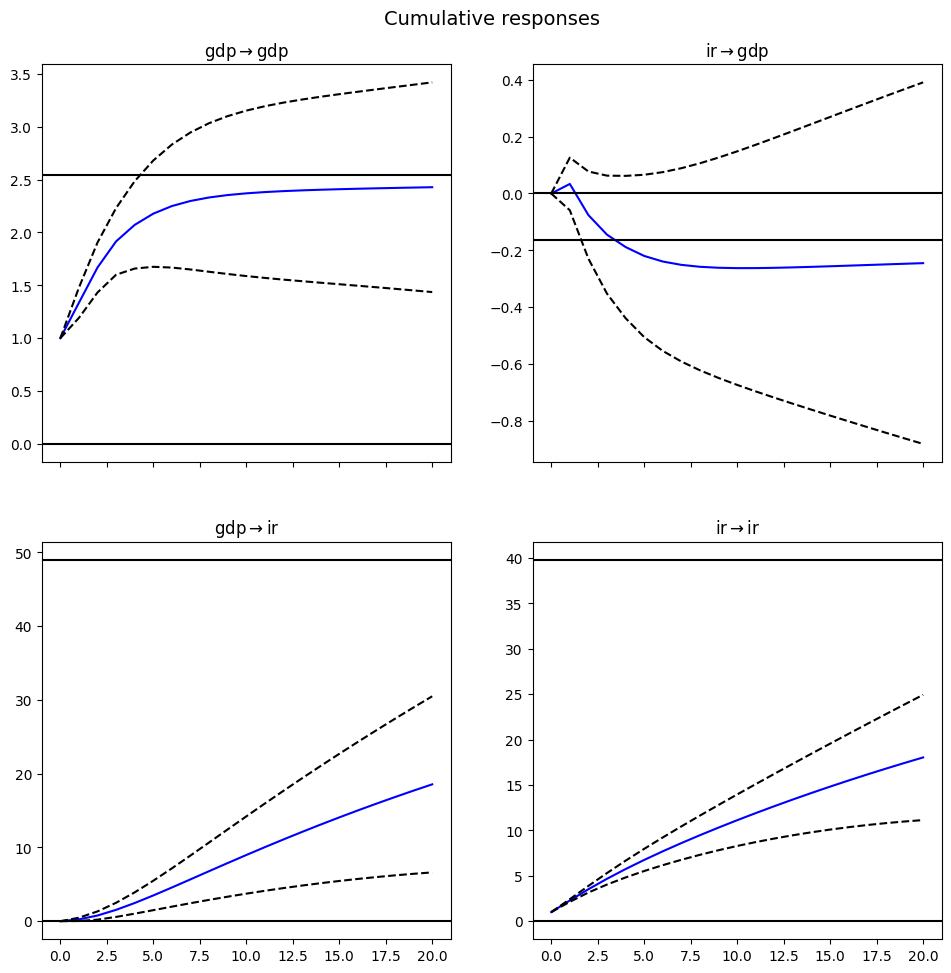

In [9]:
accumulated_response = t_var_3.irf(20)

accumulated_response.plot()
plt.show()

accumulated_response.plot_cum_effects()
plt.show()

## e. Estimating VAR(2) model of GDP, Inflation and Interest Rate
Luckely we can just use the function we created for b.

In [10]:
var_2_B_hat, _, var_2_Z, var_2_sigma_LS = VAR_estimation(2, {"gdp", "ir", "cpi"}, fr_fin_df)
var_2_B_hat

The VAR(2) model is stable.


,const,gdp-1,ir-1,cpi-1,gdp-2,ir-2,cpi-2
gdp,0.231588,0.360826,0.007246,-0.059668,0.219745,-0.016884,0.068745
ir,-0.082461,0.268125,1.235995,0.034240,0.098974,-0.287618,0.003257
cpi,-0.035597,0.135468,0.106773,1.381140,0.064942,-0.107050,-0.399557


We again check using the Statsmodels library.

In [11]:
var_2_gdp_ir_cpi = VAR(fr_fin_df[["gdp", "ir", "cpi"]]).fit(2)
var_2_gdp_ir_cpi.params.T

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


,const,L1.gdp,L1.ir,L1.cpi,L2.gdp,L2.ir,L2.cpi
gdp,0.231588,0.360826,0.007246,-0.059668,0.219745,-0.016884,0.068745
ir,-0.082461,0.268125,1.235995,0.034240,0.098974,-0.287618,0.003257
cpi,-0.035597,0.135468,0.106773,1.381140,0.064942,-0.107050,-0.399557


## f. Granger-cause test

In [97]:
def granger_causality_test(causing: list[str], cause: list[str], data_df: pd.DataFrame, B_hat: pd.DataFrame, p: int, Z: pd.DataFrame, sigma_LS: pd.DataFrame, T: int, K: int):
    N = len(causing) * p # number of restrictions
    B_hat_vec = B_hat.values.flatten("F")
    C_raw = B_hat.copy()
    cause = [f"{c}-{i+1}" for i in range(p) for c in cause]
    C_raw.loc[causing, cause] = True
    C_between =  (C_raw == True).astype(int).values.flatten("F")
    C = np.zeros((N, len(B_hat_vec)))
    
    # This is the stupidest code ever created, however it does work
    _last = 0
    for j in range(N):
        for i in range(_last, len(B_hat_vec)):
            if C_between[i] == 1:
                C[j, i] = 1
                _last = i + 1
                break
        
    test_stat = 1/N * (C @ B_hat_vec).T @ np.linalg.inv(C @ (np.kron(np.linalg.inv(Z @ Z.T), sigma_LS) @ C.T)) @ (C @ B_hat_vec)
    display(test_stat)

    return sts.f.sf(test_stat, N, K * T - K **2* p - K), test_stat

granger_causality_test(["gdp", "cpi"], ["ir"], fr_fin_df, var_2_B_hat, 2, var_2_Z, var_2_sigma_LS, 200, 3)

1.2371732200959997

(0.2939106436586204, 1.2371732200959997)

Thus we have that the value of $\lambda = 1.237$, and a p-value $0.294$, thus we reject the Granger-cause. Finally we also compare our results to the Statsmodels results.

In [ ]:
var_2_gdp_ir_cpi.test_causality(["gdp", "cpi"], "ir").summary()

Test statistic,Critical value,p-value,df
1.237,2.387,0.294,"(4, 573)"
